In [ ]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalMSELoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = True #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv"
AUC_df_path = "../data/DAPL/gdsc1+2_ccle_z-score_sorted.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/DAPL/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32], # Dr.Chiu:exp[500,200,50] [1000,100,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 2
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = False
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04
criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
#criterion =  FocalMSELoss(alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05)
metrics_type_set = [ "MAE", "R^2"] #"MSE",
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)


dense_layer_dim 132


In [32]:
set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed  
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Exp tensor shape: torch.Size([76, 1426])
Exp num_features 1426


In [ ]:
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
AUC_df = pd.read_csv( AUC_df_path, sep=',', index_col=0)

# matched AUCfile and omics_data samples
print(drug_df.shape)
print(AUC_df.shape)
# get_data_value_range(AUC_df.values.tolist(),"AUC_df", file=None)
# sns.kdeplot(np.concatenate(np.array(AUC_df.values)), fill=True, color='blue')
# plt.show()

matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)
    
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

(1440, 9)
(966, 449)
AUC_df (42, 449)
drug_df (1440, 9)
AUC_df (42, 449)


EXP : 
Range: 1.00000000
Minimum: 0.00000000
Maximum: 1.00000000
Mean: 0.41441883
Median: 0.43089333
Standard Deviation: 0.30707557
Skewness: 0.08946851
binary data:False
-------------------------------------


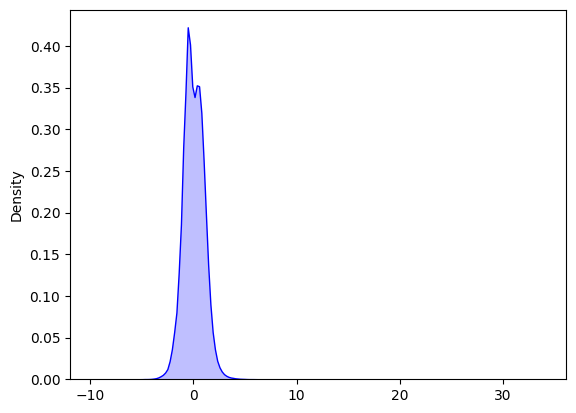

In [ ]:
# from utils.tools import get_data_value_range
# get_data_value_range(omics_data_dict["Exp"].values.tolist(),"EXP", file=None)
# sns.kdeplot(np.concatenate(np.array(exp_df_sorted.values)), fill=True, color='blue')
# plt.show()

In [ ]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)


if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

batch_size 3 num_epoch: 2
drug_df (42, 9)
AUC_df (76, 42)
kfoldCV 2
weighted_threshold: None


In [ ]:
import codecs
from subword_nmt.apply_bpe import BPE
import numpy as np

def drug2emb_encoder(smile,vocab_path,sub_csv, max_d=50): # drug_smiles['smiles']
    
    bpe_codes_drug = codecs.open(vocab_path) # token
    # dbpe: initiate BPE function 
    dbpe = BPE(bpe_codes_drug, merges=-1, separator='') # merges=-1 : no limit on the number of merge operations, and BPE will continue merging subword units until it can no longer find any meaningful merges. 
                                                        #In other words, it will keep merging until the training process converges.
                                                        #separator='' : uses an empty string ('') as a separator between subword units.
    idx2word_d = sub_csv['index'].values # index : substructure EX:CC
    words2idx_d = dict(zip(idx2word_d, range(0, len(idx2word_d))))# zip substructure with it's substructure character length. EX:(CC,2)

    tokens = dbpe.process_line(smile).split() # BPE tokenizes the input SMILES # tokens=vocabulary set # ex:[ 'Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3' ]
        # tokens: list of subwords of a word
    try:
        i1 = np.asarray([words2idx_d[subword ] for subword  in tokens]) # i1: subword在sub_csv file中的index ; i: tokens中的subword
    except:# 如果tokens是空值，或tokens中有subword沒有在words2idx_d字典裡
        i1 = np.array([0])
    l = len(i1)
    if l < max_d: # subword list 長度小於50
        i = np.pad(i1, (0, max_d - l), 'constant', constant_values=0) # 補零補到50，前面是subword在sub_csv file中的index
        input_mask = ([1] * l) + ([0] * (max_d - l)) # i的mask
    else: # subword list 長度大於等於50
        i = i1[:max_d] # 取前50個subwords(index) # !!!!須改方法!!!!
        input_mask = [1] * max_d # i的mask
    return i, np.asarray(input_mask),tokens

In [ ]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  76 42
torch.Size([76, 42])
['Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3', 'O[C@@H]4', 'CO', 'P', '(O)', '(=O)', 'O[C@H]4', '[C@H]3', 'O)c2', 'n1']


In [ ]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (60,)
id_unrepeat_val (8,)
id_unrepeat_test (8,)
id_unrepeat_train_val (68,)
id_test.shape (336,)


In [ ]:
print(id_test[:10])

[630 631 632 633 634 635 636 637 638 639]
